# 语义分割

- 目标检测的框太糙了
- 语义分割提供像素级的精度
    - 实例分割：将同一类的物体分别标出来

In [1]:
# Pascal VOC2012
%matplotlib inline
import os
import torch
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
from d2l import torch as d2l

In [2]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar', '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [3]:
def read_voc_images(voc_dir, is_train=True):
    """ 读取所有的VOC图像并标注 """
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation', 'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(
            torchvision.io.read_image(
                os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg')
            )
        )
        # 目标分割的labels实际上相当于一张图片，使用没有压缩过的png进行保存
        labels.append(
            torchvision.io.read_image(
                os.path.join(voc_dir, 'SegmentationClass', f'{fname}.png'),
                mode
            )
        )
    return features, labels
train_features, train_labels = read_voc_images(voc_dir, is_train=True)

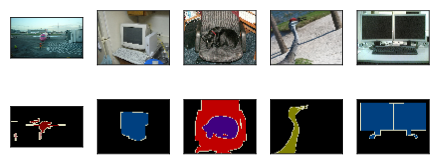

In [4]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
# pytorch 和 matplotlib 通道维度位置不一样
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.set_figsize((7, 14))
d2l.show_images(imgs, 2, n);

In [5]:
a = Image.open('../data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png')

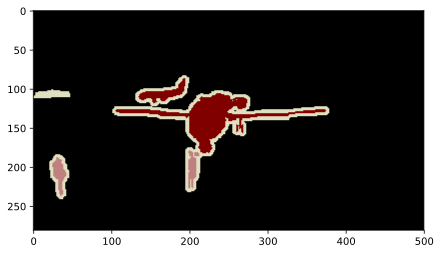

In [6]:
plt.imshow(a)

In [7]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [8]:
def voc_colormap2label():
    """ 使用torch而不是python实现，避免运算缓慢"""
    colormap2label = torch.zeros(256**3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])
    return colormap2label[idx]

In [9]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

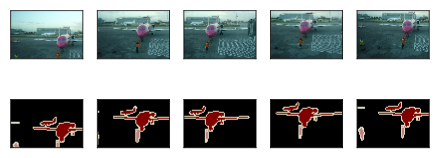

In [10]:
""" 随机裁剪 """
def voc_rand_crop(feature, label, height, width):
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width)
    ) # 得到随机裁剪的裁剪框 保证label和feature像素对应
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

In [11]:
class VOCSegDataset(torch.utils.data.Dataset):
    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize( # imagenet
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        )
        # 由于VOC的每一张图片大小不一样，而对label来说 Resize 是比较困难的，插值会导致类别变化
        # 使用 crop 保证批量的大小固定
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [
            self.transform(img.float())
            for img in self.filter(features)
        ]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')
        
    def filter(self, imgs):
        # 滤除大小小于裁切值的图片
        return [
            img for img in imgs if (
                img.shape[1] >= self.crop_size[0] and
                img.shape[2] >= self.crop_size[1]
            )
        ]
    
    def __getitem__(self, idx):
        feature, label = voc_rand_crop(
            self.features[idx], self.labels[idx], *self.crop_size
        )
        return (feature, voc_label_indices(label, self.colormap2label))
    
    def __len__(self):
        return len(self.features)

In [12]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [16]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(
    voc_train, batch_size, shuffle=True, drop_last=True
)
for X, y in train_iter:
    print(X.shape)
    print(y.unsqueeze(1).shape)
    break

torch.Size([64, 3, 320, 480])
torch.Size([64, 1, 320, 480])
